# Final Project Phase 3 - Home Credit Default Risk

Spring 2024

**Team Members:**
- Glen Colletti
- Alex Bordanca
- Paul Miller

## Abstract
In phase three the goal was to improve the ability of our models to predict the TARGET feature by incorporating data outside the application train csv. To do this the team focused on feature engineering and hyperparameter tuning of the modeling pipelines. \\

Recency, Frequency, and Monetary Value (RFM) features were added to the test and train data. These metrics are common in marketing analysis to compare segments of the customer base. Recency measures how recently an applicant was given a loan. Frequency gauges how often an applicant receives loans. Monetary value reflects the total sum of all loans let by Home Credit to the applicant. The RFM features were derived from features in the previous application csv. We discovered anomalies in several of the previous application features.

Preprocessing pipelines were implemented to automate this task.

In [ ]:
from pandas import concat, DataFrame,read_csv, set_option
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from __future__ import print_function

import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from scipy.stats import uniform, randint

from xgboost import XGBClassifier

np.random.seed(42)

# Suppress scientific notation and use 3 decimal places
set_option('display.float_format', '{:.3f}'.format)

All data downloaded from Kaggle:

https://www.kaggle.com/competitions/home-credit-default-risk/data

There are several other data files which contain information regarding a customer's financial profile, payment history etc obtained from Kaggle:
- `bureau.csv`
- `bureau_balance.csv`
- `credit_card_balance.csv`
- `installments_payments.csv`
- `previous_application.csv`
- `POS_CASH_balance.csv`

The baseline pipelines will only use data loaded from `application_train.csv`

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"alexbordanca","key":"d9c74782ba569bbacddf222b676a9d32"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                             Online Food Dataset                               3KB  2024-03-02 18:50:30          27375        533  0.9411765        
nbroad/gemma-rewrite-nbroad                                     gemma-rewrite-nbroad                              8MB  2024-03-03 04:52:39           1689        105  1.0              
startalks/pii-models                                            pii-models                                        1GB  2024-03-21 21:23:40            148         22  1.0              
sukhmandeepsinghbrar

In [ ]:
import os
DATA_DIR = "/HCDR/DATA_DIR/"   #same level as course repo in the data directory
#DATA_DIR = os.path.join('./ddddd/')
!mkdir DATA_DIR

! kaggle competitions download home-credit-default-risk -p $DATA_DIR
!ls -l $DATA_DIR

mkdir: cannot create directory ‘DATA_DIR’: File exists
home-credit-default-risk.zip: Skipping, found more recently modified local copy (use --force to force download)
total 3326076
-rw-r--r-- 1 root root  26567651 Apr 16 21:30 application_test.csv
-rw-r--r-- 1 root root 166133370 Apr 16 21:30 application_train.csv
-rw-r--r-- 1 root root 375592889 Apr 16 21:30 bureau_balance.csv
-rw-r--r-- 1 root root 170016717 Apr 16 21:30 bureau.csv
-rw-r--r-- 1 root root 424582605 Apr 16 21:30 credit_card_balance.csv
-rw-r--r-- 1 root root     37383 Apr 16 21:30 HomeCredit_columns_description.csv
-rw-r--r-- 1 root root 721616255 Dec 11  2019 home-credit-default-risk.zip
-rw-r--r-- 1 root root 723118349 Apr 16 21:30 installments_payments.csv
-rw-r--r-- 1 root root 392703158 Apr 16 21:30 POS_CASH_balance.csv
-rw-r--r-- 1 root root 404973293 Apr 16 21:30 previous_application.csv
-rw-r--r-- 1 root root    536202 Apr 16 21:30 sample_submission.csv


In [ ]:
import zipfile
unzippingReq = True #True# if unzippingReq: #please modify this code
zip_ref = zipfile.ZipFile(f'{DATA_DIR}/home-credit-default-risk.zip', 'r')
     # extractall():  Extract all members from the archive to the current working directory. path specifies a different directory to extract to
zip_ref.extractall(f'{DATA_DIR}')
zip_ref.close()

In [ ]:
!ls -l $DATA_DIR

total 3326076
-rw-r--r-- 1 root root  26567651 Apr 16 21:42 application_test.csv
-rw-r--r-- 1 root root 166133370 Apr 16 21:42 application_train.csv
-rw-r--r-- 1 root root 375592889 Apr 16 21:42 bureau_balance.csv
-rw-r--r-- 1 root root 170016717 Apr 16 21:42 bureau.csv
-rw-r--r-- 1 root root 424582605 Apr 16 21:42 credit_card_balance.csv
-rw-r--r-- 1 root root     37383 Apr 16 21:42 HomeCredit_columns_description.csv
-rw-r--r-- 1 root root 721616255 Dec 11  2019 home-credit-default-risk.zip
-rw-r--r-- 1 root root 723118349 Apr 16 21:43 installments_payments.csv
-rw-r--r-- 1 root root 392703158 Apr 16 21:42 POS_CASH_balance.csv
-rw-r--r-- 1 root root 404973293 Apr 16 21:43 previous_application.csv
-rw-r--r-- 1 root root    536202 Apr 16 21:43 sample_submission.csv


In [ ]:
train_data = read_csv('/HCDR/DATA_DIR/application_train.csv')

print(f'Loaded {train_data.shape[0]:,} records.')
print()
train_data.head()

Loaded 307,511 records.



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.500,29686.500,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.000,21865.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000


Explore missing data in training dataset

In [ ]:
#MISSING DATA FOR APPLICATION TRAIN

percent = (train_data.isnull().sum() / train_data.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = train_data.isna().sum().sort_values(ascending = False)
missing_application_train_data  = concat([percent, sum_missing], axis=1, keys=['Percent', "Train Missing Count"])
missing_application_train_data.head(20)

,Percent,Train Missing Count
COMMONAREA_MEDI,69.870,214865
COMMONAREA_AVG,69.870,214865
COMMONAREA_MODE,69.870,214865
NONLIVINGAPARTMENTS_MODE,69.430,213514
NONLIVINGAPARTMENTS_AVG,69.430,213514
NONLIVINGAPARTMENTS_MEDI,69.430,213514
FONDKAPREMONT_MODE,68.390,210295
LIVINGAPARTMENTS_MODE,68.350,210199
LIVINGAPARTMENTS_AVG,68.350,210199
LIVINGAPARTMENTS_MEDI,68.350,210199


## Features

### Correlations

Find the features most correlated to the target. In Phase 2 we limited this to the 10 most positive and 10 most negative. In this phase we expanded that scope to the 20 most positive and 20 most negative.

After listing the most correlated features to the target, we created Seaborn heat maps to test for multicollinearity (if the features are correlated to each other.)

We discovered many features could be safely dropped since they are strongly correlated to a slightly different column.

For example FLOORSMAX_MODE is strongly correlated to FLOORSMAX_MEDI, so we used only FLOORSMAX_MEDI as a model feature.

### Correlations to target

In [ ]:
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
correlations = train_data[numeric_columns].corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 FLAG_DOCUMENT_3               0.044
REG_CITY_NOT_LIVE_CITY        0.044
FLAG_EMP_PHONE                0.046
REG_CITY_NOT_WORK_CITY        0.051
DAYS_ID_PUBLISH               0.051
DAYS_LAST_PHONE_CHANGE        0.055
REGION_RATING_CLIENT          0.059
REGION_RATING_CLIENT_W_CITY   0.061
DAYS_BIRTH                    0.078
TARGET                        1.000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.179
EXT_SOURCE_2                 -0.160
EXT_SOURCE_1                 -0.155
DAYS_EMPLOYED                -0.045
FLOORSMAX_AVG                -0.044
FLOORSMAX_MEDI               -0.044
FLOORSMAX_MODE               -0.043
AMT_GOODS_PRICE              -0.040
REGION_POPULATION_RELATIVE   -0.037
ELEVATORS_AVG                -0.034
Name: TARGET, dtype: float64


Print out most correlated features in list form to use when modeling.

In [ ]:
most_pos_corr = correlations.tail(21)
most_neg_corr = correlations.head(20)

neg_cols = most_neg_corr.index.to_list()
pos_cols = most_pos_corr.index.to_list()

### Check for multicollinearity in the top 20 features

We use only 10,000 randomly sampled rows as the original dataset was slow to work with.

In [ ]:
train_data = train_data.sample(10_000)

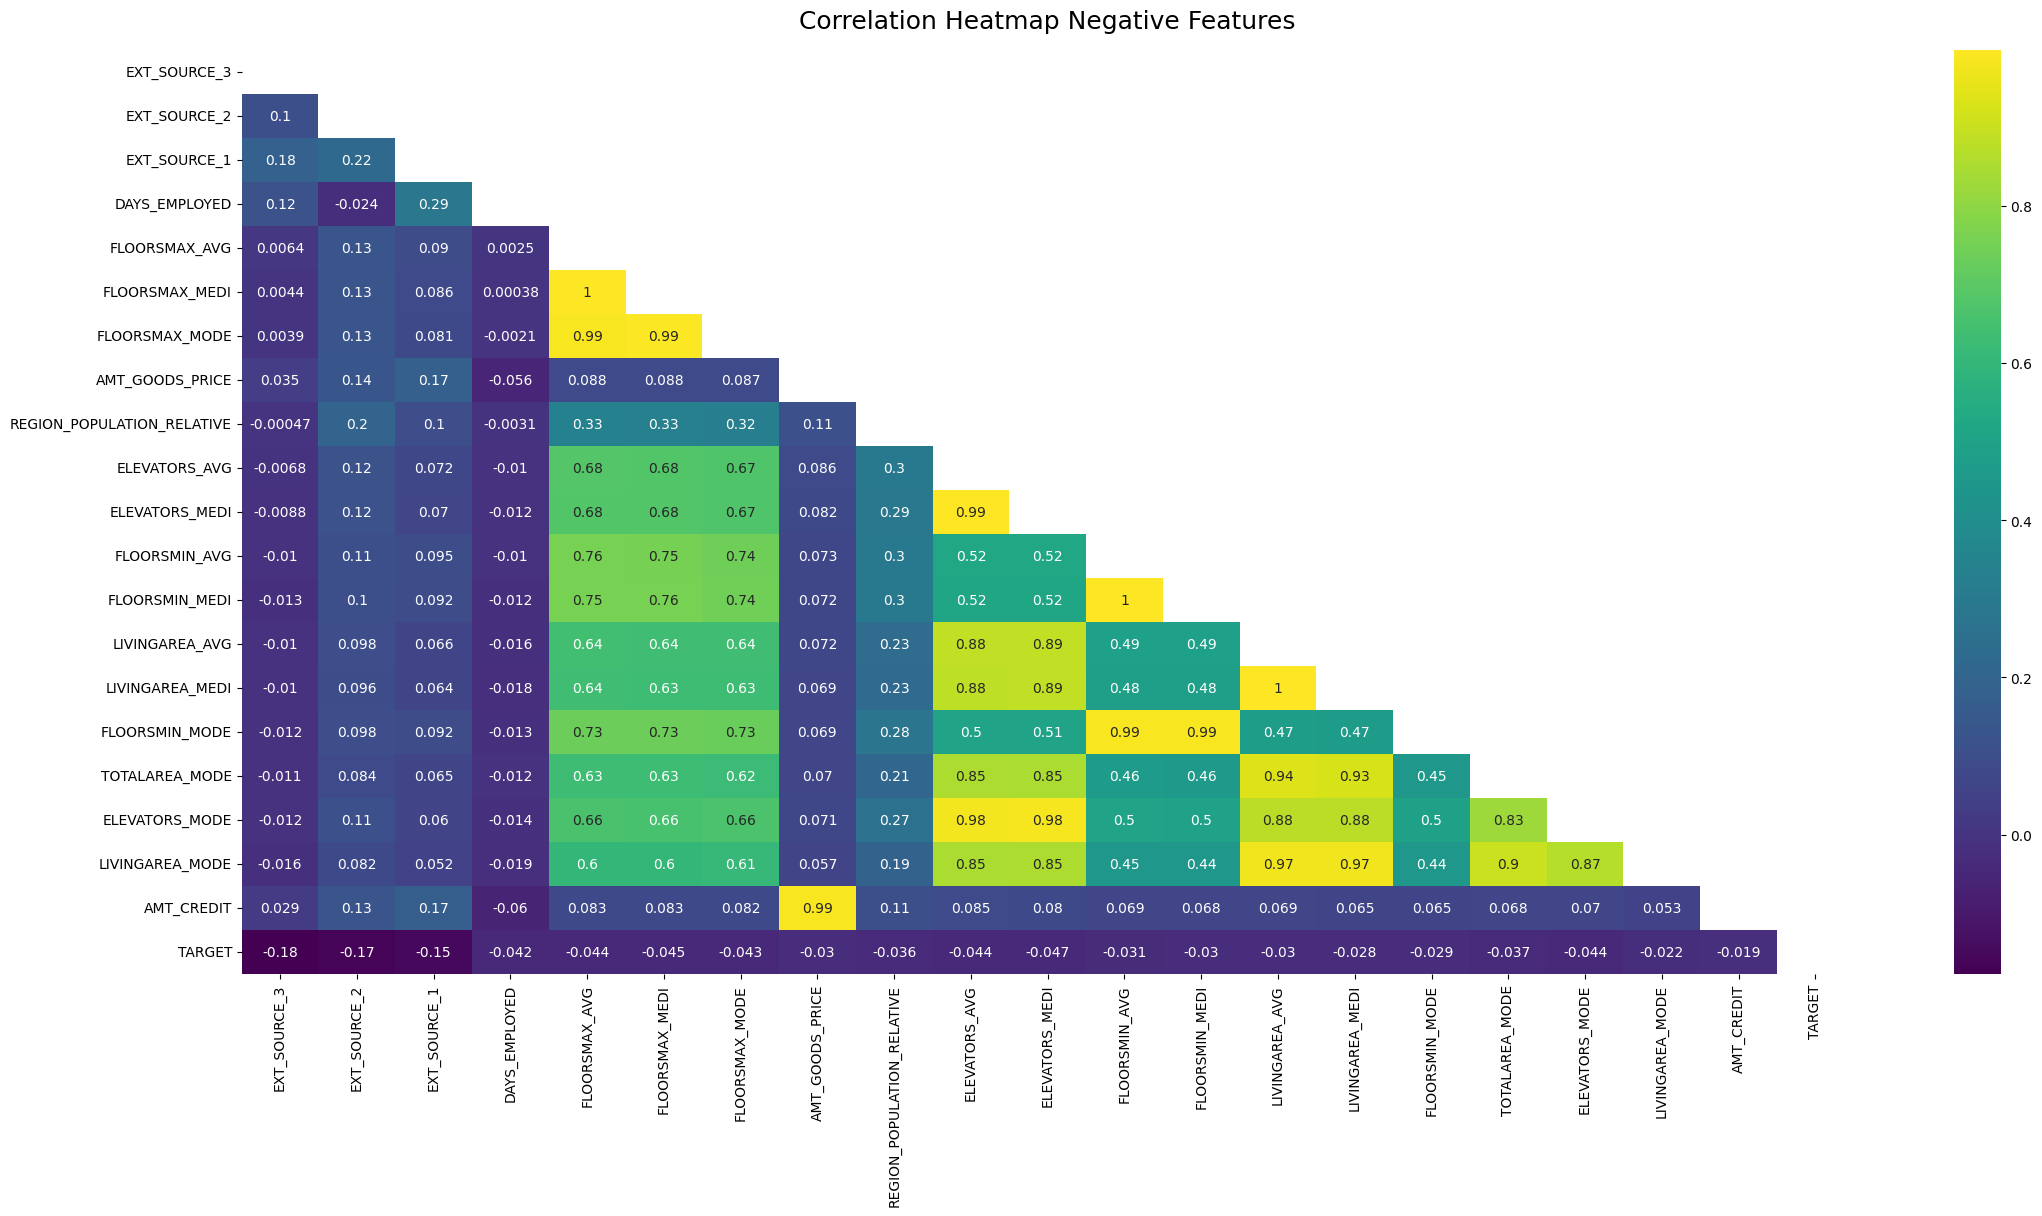

In [ ]:
 plt.figure(figsize=(26, 12))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(train_data[neg_cols + ['TARGET']].corr(), dtype=bool))

top_20_heatmap = sns.heatmap(train_data[neg_cols + ['TARGET']].corr(), mask=mask, annot=True, cmap='viridis')

top_20_heatmap.set_title('Correlation Heatmap Negative Features', fontdict={'fontsize':18}, pad=16);

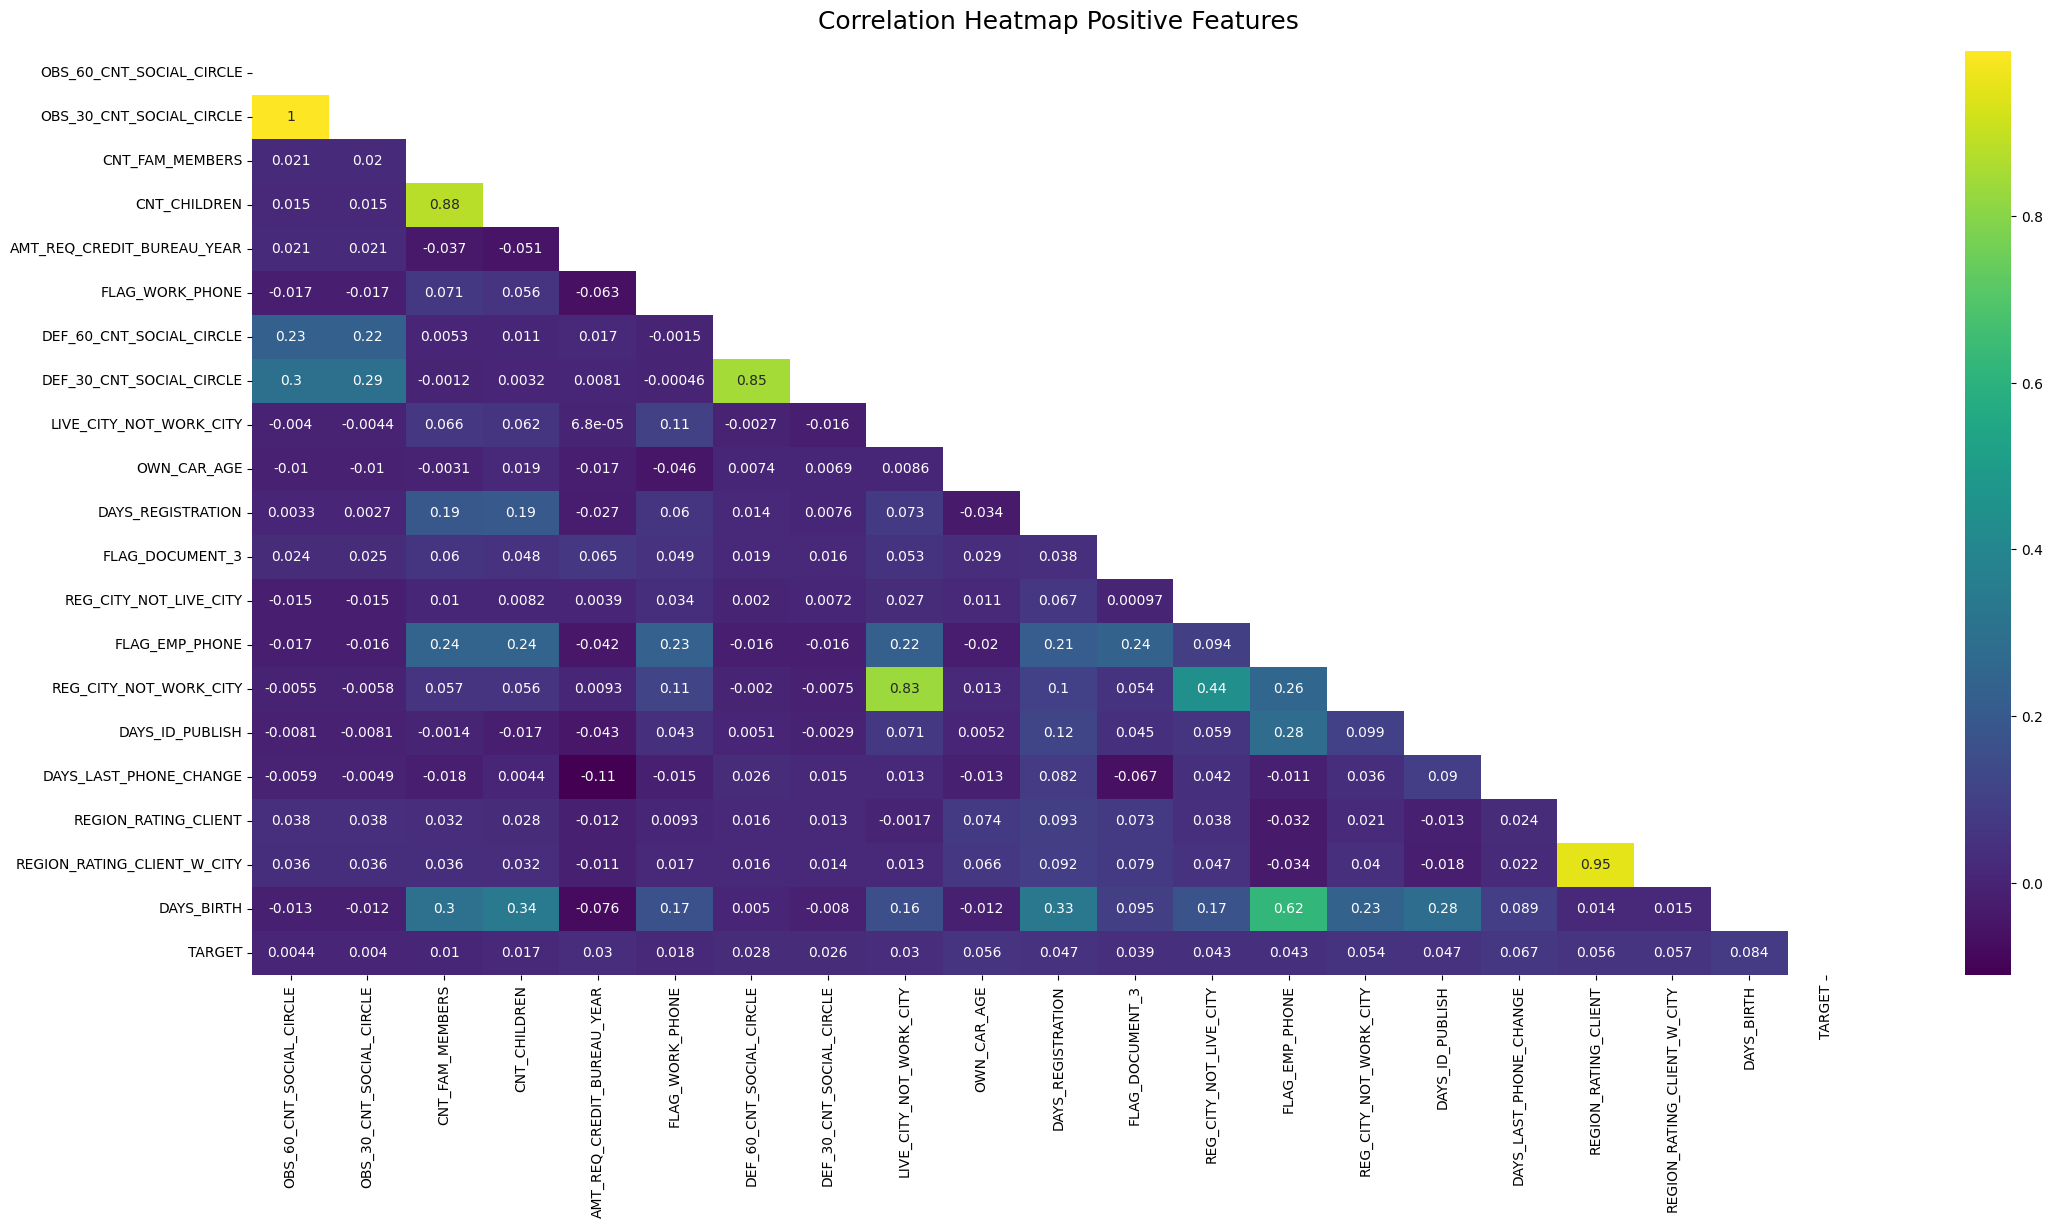

In [ ]:
 plt.figure(figsize=(26, 12))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(train_data[pos_cols].corr(), dtype=bool))

top_20_heatmap = sns.heatmap(train_data[pos_cols].corr(), mask=mask, annot=True, cmap='viridis')

top_20_heatmap.set_title('Correlation Heatmap Positive Features', fontdict={'fontsize':18}, pad=16);

### Recency, Frequency and Monetary feature

Recency: How recently a customer has made  a purchase. Time elapsed since customer's last purchase.

Frequency: How often a customer purchases. Number of transactions a customer has made.

Monetary: Represents how much money customer has spent on purchases. Sum of all transactions.

Typically each measure is scaled 1 to 5 with 5 being the best customer (recent purchase, frequent purchases, high spending)

**How to translate to loans?**

Monetary seems to translate well to loans. An applicant who borrows large amounts of money, all else being equal, would be a good customer. Then again if an appicant just borrowed a lot of money, it might not be logical to loan them even more money. Maybe the other features will account for how well the applicant is managing the previous high dollar loan.  

Frequnecy might do ok with loans. An applicant who borrows frequnently, all else being equal, would be a good customer.

Recency might not do as well with loans. Is it good that a recent customer would be applying for another loan? This might depend quite a bit on what the loans are for. A business might take out loans frequently if it is part of their business model to loan money to start projects customers will pay for (home construction comes to mind).  

### Inspect loan amount the customer is applying for (`AMT_CREDIT` column)

This feature is not very important, but does have a -0.03 correlation to the target variable.

In [ ]:
correlations["AMT_CREDIT"]

-0.03036928646142988

In [ ]:
train_data["AMT_CREDIT"].describe()

count     10000.000
mean     601382.803
std      405995.920
min       45000.000
25%      270000.000
50%      512721.000
75%      810000.000
max     3600000.000
Name: AMT_CREDIT, dtype: float64

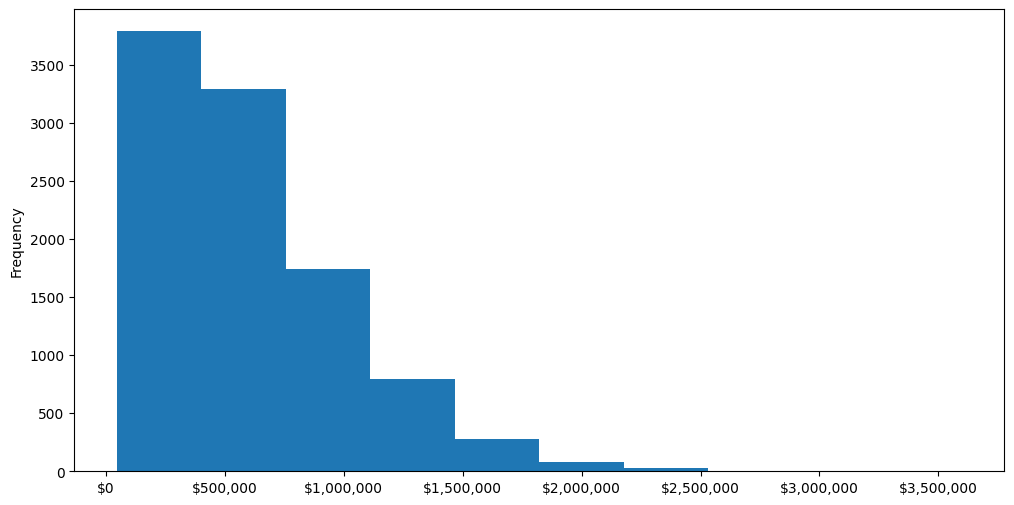

In [ ]:
plt.figure(figsize=(12, 6))

ax = plt.gca()

def format_dollars(x, pos):
    """Format a number in dollars with commas."""
    return "${:,.0f}".format(x)

# Set the x-axis tick formatter to use the custom function
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

ax.ticklabel_format(axis='y', style='plain')
train_data["AMT_CREDIT"].plot.hist();

There are some extremely high values that could be skewing the model's performance. One possible solution is to create a new feature which would create bins of the amounts.

For example, create bins of small, medium and large loan values.

We attempted to create a Transformer to perform this logic in a pipeline but ultimately could figure out the correct Python code to implement it.

In [ ]:
# Define the bin edges for 'small', 'medium', and 'large' loans
bin_edges = (45000, 200000, 800000, 3000000)

# Define the corresponding category labels
bin_labels = ['small', 'medium', 'large']

### `DAYS_EMPLOYED` feature analysis


In performing deeper analysis of the feature set, we found that the `DAYS_EMPLOYED` feature analysis column contained many rows of the number 365243. The Kaggle documentation describes this column as "How many days before the application the person started current employment" and expects a negative value.

In [ ]:
train_data['DAYS_EMPLOYED'].describe()

count    10000.000
mean     62648.627
std     140304.398
min     -16607.000
25%      -2771.250
50%      -1188.500
75%       -292.000
max     365243.000
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
# Convert the value counts to a DataFrame
days_employed_counts = train_data['DAYS_EMPLOYED'].value_counts().to_frame().reset_index()

# Rename columns if necessary
days_employed_counts.columns = ['Value', 'Count']

# Sort by Count in descending order
days_employed_counts.sort_values(by='Count', ascending=False)[:10]

,Value,Count
0,365243,1769
2,-194,10
1,-118,10
8,-161,8
12,-237,8
11,-185,8
10,-609,8
9,-287,8
13,-232,8
7,-201,8


After keeping only negative values, the `DAYS_EMPLOYED` = "How many days before the application the person started current employment"

In [ ]:
train_data[train_data['DAYS_EMPLOYED'] < 0]['DAYS_EMPLOYED'].describe()

count     8231.000
mean     -2384.716
std       2372.393
min     -16607.000
25%      -3178.000
50%      -1625.000
75%       -752.500
max         -9.000
Name: DAYS_EMPLOYED, dtype: float64

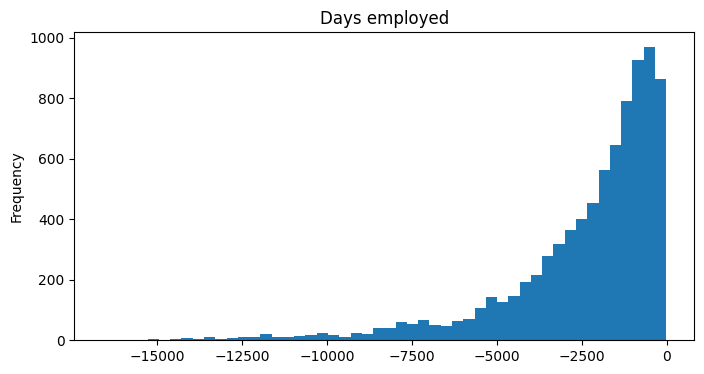

In [ ]:
plt.figure(figsize=(8, 4))

ax = plt.gca()

ax.ticklabel_format(axis='y', style='plain')

plt.title('Days employed')
train_data[train_data['DAYS_EMPLOYED'] < 0]['DAYS_EMPLOYED'].plot.hist(bins=50);

The histogram plot above shows the `DAYS_EMPLOYED` values after removing the erroneous rows containing 365243.

### Model feature list

The final list of features to be used as inputs to the models.
* FLOORSMAX_MEDI
* ELEVATORS_MEDI
* FLOORSMIN_MEDI
* AMT_CREDIT
* TOTALAREA_MODE
* DAYS_EMPLOYED
* OBS_30_CNT_SOCIAL_CIRCLE
* CNT_FAM_MEMBERs
* CNT_CHILDREN
* OWN_CAR_AGE
* DAYS_ID_PUBLISH
* DAYS_LAST_PHONE_CHANGE
* CODE_GENDER
* OCCUPATION_TYPE
* AMT_INCOME_TOTAL
  
Newly engineered features:
* RECENCY_FEATURE
* FREQUENCY_FEATURE
* MONETARY_VALUE


# Train, Test, Split data from `application_train.csv`

Initial attempts were crashing kernels because the dataset was too large (over 300,000 records)

We are taking a random sample of 10,000 rows to allow our models to function. Future models may expand the size of the model training set to improve model performance.

In [ ]:
train_data.shape

(10000, 122)

Create training, validation and testing data.

In [ ]:
X = train_data.drop('TARGET', axis=1)
y = train_data['TARGET']

# Split the provided training data into training and validationa and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")


X_train.head()

X train           shape: (6800, 121)
X validation      shape: (1700, 121)
X test            shape: (1500, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
297168,444286,Cash loans,M,Y,Y,1,112500.000,301464.000,23949.000,238500.000,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
195175,326321,Cash loans,F,Y,Y,1,180000.000,675000.000,32602.500,675000.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
105807,222774,Cash loans,F,N,N,0,135000.000,1066320.000,38299.500,900000.000,...,0,0,0,0,0.000,0.000,1.000,0.000,0.000,2.000
40228,146602,Cash loans,F,N,N,1,67500.000,339241.500,15943.500,238500.000,...,0,0,0,0,0.000,0.000,0.000,0.000,1.000,0.000
15971,118637,Cash loans,F,N,N,0,135000.000,450000.000,16965.000,450000.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,3.000


# Pipelines

## Pipeline Block Diagrams

![Screenshot 2024-04-16 at 7.46.21 PM.png](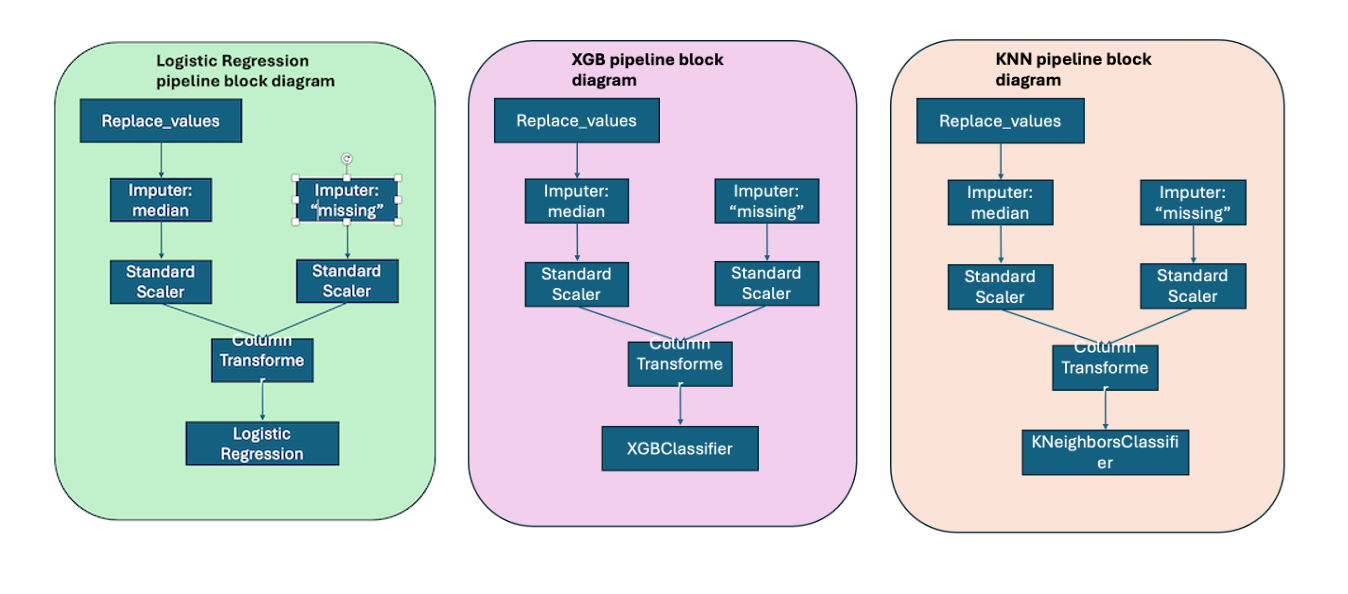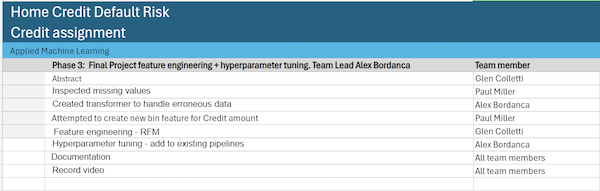)

## Dataset issue

Data is organized by loan ID not customer ID

# Load Dependencies and data

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

In [ ]:
# DATA_DIR = "/HCDR/DATA_DIR"   #same level as course repo in the data directory
# #DATA_DIR = os.path.join('./ddddd/')
# !mkdir DATA_DIR

# ! kaggle competitions download home-credit-default-risk -p $DATA_DIR
# !ls -l $DATA_DIR

In [ ]:
# import zipfile
# unzippingReq = True #True
# if unzippingReq: #please modify this code
#     zip_ref = zipfile.ZipFile(f'{DATA_DIR}/home-credit-default-risk.zip', 'r')
#     # extractall():  Extract all members from the archive to the current working directory. path specifies a different directory to extract to
#     zip_ref.extractall(f'{DATA_DIR}')
#     zip_ref.close()

In [ ]:
# !ls -l $DATA_DIR

In [ ]:
import pandas as pd
train_data = pd.read_csv('/HCDR/DATA_DIR/application_train.csv') #data we have the target class for

test_data = pd.read_csv('/HCDR/DATA_DIR/application_test.csv') #data we need to predict target class for, for competition

col_names = test_data.columns.values.tolist()
col_names.sort()
print(col_names)

['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CODE_GENDER', 'COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 

## Feature Engineering

In [ ]:
import numpy as np
import pandas as pd
PrevApp_data = pd.read_csv('/HCDR/DATA_DIR/previous_application.csv') #data from previous applications to Home Credit
print(np.shape(PrevApp_data))
col_names = PrevApp_data.columns.values.tolist()
col_names.sort()
print(col_names)

(1670214, 37)
['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'CHANNEL_TYPE', 'CNT_PAYMENT', 'CODE_REJECT_REASON', 'DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_TERMINATION', 'FLAG_LAST_APPL_PER_CONTRACT', 'HOUR_APPR_PROCESS_START', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CLIENT_TYPE', 'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PAYMENT_TYPE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'NFLAG_INSURED_ON_APPROVAL', 'NFLAG_LAST_APPL_IN_DAY', 'PRODUCT_COMBINATION', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'SELLERPLACE_AREA', 'SK_ID_CURR', 'SK_ID_PREV', 'WEEKDAY_APPR_PROCESS_START']


In [ ]:
PrevApp_data.head(5)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.000,17145.000,0.000,17145.000,SATURDAY,15,...,Connectivity,12.000,middle,POS mobile with interest,365243.000,-42.000,300.000,-42.000,-37.000,0.000
1,2802425,108129,Cash loans,25188.615,607500.000,679671.000,NaN,607500.000,THURSDAY,11,...,XNA,36.000,low_action,Cash X-Sell: low,365243.000,-134.000,916.000,365243.000,365243.000,1.000
2,2523466,122040,Cash loans,15060.735,112500.000,136444.500,NaN,112500.000,TUESDAY,11,...,XNA,12.000,high,Cash X-Sell: high,365243.000,-271.000,59.000,365243.000,365243.000,1.000
3,2819243,176158,Cash loans,47041.335,450000.000,470790.000,NaN,450000.000,MONDAY,7,...,XNA,12.000,middle,Cash X-Sell: middle,365243.000,-482.000,-152.000,-182.000,-177.000,1.000
4,1784265,202054,Cash loans,31924.395,337500.000,404055.000,NaN,337500.000,THURSDAY,9,...,XNA,24.000,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
!pip install --upgrade 'sqlalchemy<2.0'
!pip install -U pandasql

In [ ]:
from pandasql import sqldf

augmented_train_data = sqldf('''
with rfm as (select
SK_ID_CURR, sum(AMT_CREDIT) as MONETARY_VALUE,
max(DAYS_DECISION) as RECENCY_FEATURE,
(max(DAYS_DECISION) - min(DAYS_DECISION))/COUNT(DISTINCT SK_ID_PREV) as FREQUENCY_FEATURE
from PrevApp_data
where AMT_CREDIT <> 0
group by 1
)
select train.*, rfm.RECENCY_FEATURE, rfm.FREQUENCY_FEATURE, rfm.MONETARY_VALUE
from train_data train
left join rfm
on train.SK_ID_CURR = rfm.SK_ID_CURR
''')
augmented_train_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,RECENCY_FEATURE,FREQUENCY_FEATURE,MONETARY_VALUE
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,...,0,0.000,0.000,0.000,0.000,0.000,1.000,-606.000,0.000,179055.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,...,0,0.000,0.000,0.000,0.000,0.000,0.000,-746.000,531.000,1452573.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,...,0,0.000,0.000,0.000,0.000,0.000,0.000,-815.000,0.000,20106.000
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.500,29686.500,...,0,NaN,NaN,NaN,NaN,NaN,NaN,-181.000,72.000,2625259.500
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.000,21865.500,...,0,0.000,0.000,0.000,0.000,0.000,0.000,-374.000,330.000,999832.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.000,254700.000,27558.000,...,0,NaN,NaN,NaN,NaN,NaN,NaN,-273.000,0.000,40455.000
307507,456252,0,Cash loans,F,N,Y,0,72000.000,269550.000,12001.500,...,0,NaN,NaN,NaN,NaN,NaN,NaN,-2497.000,0.000,56821.500
307508,456253,0,Cash loans,F,N,Y,0,153000.000,677664.000,29979.000,...,0,1.000,0.000,0.000,1.000,0.000,1.000,-1909.000,471.000,41251.500
307509,456254,1,Cash loans,F,N,Y,0,171000.000,370107.000,20205.000,...,0,0.000,0.000,0.000,0.000,0.000,0.000,-277.000,22.000,268879.500


In [ ]:
filtered_train_data = sqldf('''
SELECT
  TARGET,
  FLOORSMAX_MEDI,
  ELEVATORS_MEDI,
  FLOORSMIN_MEDI,
  AMT_CREDIT,
  TOTALAREA_MODE,
  DAYS_EMPLOYED,
  OBS_30_CNT_SOCIAL_CIRCLE,
  CNT_FAM_MEMBERs,
  CNT_CHILDREN,
  OWN_CAR_AGE,
  DAYS_ID_PUBLISH,
  DAYS_LAST_PHONE_CHANGE,
  CODE_GENDER,
  OCCUPATION_TYPE,
  AMT_INCOME_TOTAL,
  RECENCY_FEATURE,
  FREQUENCY_FEATURE,
  MONETARY_VALUE
FROM
  augmented_train_data
''')



In [ ]:
filtered_train_data

,TARGET,FLOORSMAX_MEDI,ELEVATORS_MEDI,FLOORSMIN_MEDI,AMT_CREDIT,TOTALAREA_MODE,DAYS_EMPLOYED,OBS_30_CNT_SOCIAL_CIRCLE,CNT_FAM_MEMBERS,CNT_CHILDREN,OWN_CAR_AGE,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,CODE_GENDER,OCCUPATION_TYPE,AMT_INCOME_TOTAL,RECENCY_FEATURE,FREQUENCY_FEATURE,MONETARY_VALUE
0,1,0.083,0.000,0.125,406597.500,0.015,-637,2.000,1.000,0,NaN,-2120,-1134.000,M,Laborers,202500.000,-606.000,0.000,179055.000
1,0,0.292,0.080,0.333,1293502.500,0.071,-1188,1.000,2.000,0,NaN,-291,-828.000,F,Core staff,270000.000,-746.000,531.000,1452573.000
2,0,NaN,NaN,NaN,135000.000,NaN,-225,0.000,1.000,0,26.000,-2531,-815.000,M,Laborers,67500.000,-815.000,0.000,20106.000
3,0,NaN,NaN,NaN,312682.500,NaN,-3039,2.000,2.000,0,NaN,-2437,-617.000,F,Laborers,135000.000,-181.000,72.000,2625259.500
4,0,NaN,NaN,NaN,513000.000,NaN,-3038,0.000,1.000,0,NaN,-3458,-1106.000,M,Core staff,121500.000,-374.000,330.000,999832.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0.604,0.220,0.271,254700.000,0.290,-236,0.000,1.000,0,NaN,-1982,-273.000,M,Sales staff,157500.000,-273.000,0.000,40455.000
307507,0,0.083,0.000,0.125,269550.000,0.021,365243,0.000,1.000,0,NaN,-4090,0.000,F,None,72000.000,-2497.000,0.000,56821.500
307508,0,0.167,0.000,0.208,677664.000,0.797,-7921,6.000,1.000,0,NaN,-5150,-1909.000,F,Managers,153000.000,-1909.000,471.000,41251.500
307509,1,0.042,NaN,NaN,370107.000,0.009,-4786,0.000,2.000,0,NaN,-931,-322.000,F,Laborers,171000.000,-277.000,22.000,268879.500


In [ ]:
from pandasql import sqldf

augmented_test_data = sqldf('''
with rfm as (select
   SK_ID_CURR, sum(AMT_CREDIT) as MONETARY_VALUE,
   max(DAYS_DECISION) as RECENCY_FEATURE,
   (max(DAYS_DECISION) - min(DAYS_DECISION))/COUNT(DISTINCT SK_ID_PREV) as FREQUENCY_FEATURE
from PrevApp_data
where AMT_CREDIT <> 0
group by 1
)
select train.*, rfm.RECENCY_FEATURE, rfm.FREQUENCY_FEATURE, rfm.MONETARY_VALUE
from test_data train
left join rfm
on train.SK_ID_CURR = rfm.SK_ID_CURR
''')
filtered_test_data = sqldf('''
SELECT
   FLOORSMAX_MEDI,
   ELEVATORS_MEDI,
   FLOORSMIN_MEDI,
   AMT_CREDIT,
   TOTALAREA_MODE,
   DAYS_EMPLOYED,
   OBS_30_CNT_SOCIAL_CIRCLE,
   CNT_FAM_MEMBERs,
   CNT_CHILDREN,
   OWN_CAR_AGE,
   DAYS_ID_PUBLISH,
   DAYS_LAST_PHONE_CHANGE,
   CODE_GENDER,
   OCCUPATION_TYPE,
   AMT_INCOME_TOTAL,
   RECENCY_FEATURE,
   FREQUENCY_FEATURE,
   MONETARY_VALUE
 FROM
   augmented_test_data

''')
filtered_test_data


,FLOORSMAX_MEDI,ELEVATORS_MEDI,FLOORSMIN_MEDI,AMT_CREDIT,TOTALAREA_MODE,DAYS_EMPLOYED,OBS_30_CNT_SOCIAL_CIRCLE,CNT_FAM_MEMBERS,CNT_CHILDREN,OWN_CAR_AGE,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,CODE_GENDER,OCCUPATION_TYPE,AMT_INCOME_TOTAL,RECENCY_FEATURE,FREQUENCY_FEATURE,MONETARY_VALUE
0,0.125,NaN,NaN,568800.000,0.039,-2329,0.000,2.000,0,NaN,-812,-1740.000,F,None,135000.000,-1740.000,0.000,23787.000
1,NaN,NaN,NaN,222768.000,NaN,-4469,0.000,2.000,0,NaN,-1623,0.000,M,Low-skill Laborers,99000.000,-757.000,0.000,40153.500
2,NaN,NaN,NaN,663264.000,NaN,-4458,0.000,2.000,0,5.000,-3503,-856.000,M,Drivers,202500.000,-273.000,575.000,584536.500
3,0.375,0.320,0.042,1575000.000,0.370,-1866,0.000,4.000,2,NaN,-4208,-1805.000,F,Sales staff,315000.000,-797.000,252.000,464602.500
4,NaN,NaN,NaN,625500.000,NaN,-2191,0.000,3.000,1,16.000,-4262,-821.000,M,None,180000.000,-111.000,355.000,601101.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,NaN,NaN,NaN,412560.000,NaN,-5169,1.000,1.000,0,NaN,-3399,-684.000,F,None,121500.000,-683.000,0.000,254700.000
48740,NaN,NaN,NaN,622413.000,NaN,-1149,2.000,4.000,2,NaN,-3003,0.000,F,Sales staff,157500.000,-770.000,420.000,394816.500
48741,0.333,0.160,NaN,315000.000,0.166,-3037,0.000,3.000,1,4.000,-1504,-838.000,F,None,202500.000,-84.000,377.000,265033.665
48742,0.625,0.160,NaN,450000.000,0.197,-2731,0.000,2.000,0,NaN,-1364,-2308.000,M,Managers,225000.000,-577.000,432.000,637893.000


In [ ]:
filtered_train_data.columns

Index(['TARGET', 'FLOORSMAX_MEDI', 'ELEVATORS_MEDI', 'FLOORSMIN_MEDI',
       'AMT_CREDIT', 'TOTALAREA_MODE', 'DAYS_EMPLOYED',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN',
       'OWN_CAR_AGE', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
       'CODE_GENDER', 'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL', 'RECENCY_FEATURE',
       'FREQUENCY_FEATURE', 'MONETARY_VALUE'],
      dtype='object')

# Subset the data to test pipelines

In [ ]:
#train_data = train_data.sample(1000)

#print (f'Train data size:{train_data.shape[0]} rows')

# Create models and pipelines

## Hyperparameter tuning


Below we opted for a GridSearch with Cross Validation to determine the optimal hyperparameters for our models, seeking to directly maximize the ROC AUC.

There are noticeable differences in the size of the parameter grids for the repspective models. This is due to resource allocation of compute power as some models (XGBoost) train and fit much more rapidly than the other models for a similar parameter grid.

Create a custom transformer to use on the DAYS_EMPLOYED column. This replaces any positive number with 0.

In [ ]:
class ReplaceValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column] = X_copy[self.column].apply(lambda x: 0 if x > 0 else x)
        return X_copy

## XG Boost Pipeline

In [ ]:
filtered_train_data_sample = filtered_train_data.sample(75000)
X = filtered_train_data_sample.drop(columns=['TARGET'])
y = filtered_train_data_sample['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sample data
#X = train_data.drop(columns=['TARGET'])
#y = train_data['TARGET']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define column transformer for numerical and categorical features
numeric_features = ['FLOORSMAX_MEDI', 'ELEVATORS_MEDI', 'FLOORSMIN_MEDI',
       'AMT_CREDIT', 'TOTALAREA_MODE', 'DAYS_EMPLOYED',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN',
       'OWN_CAR_AGE', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']  # List of numerical feature column indices
categorical_features = ['CODE_GENDER','OCCUPATION_TYPE']  # List of categorical feature column indices

numeric_transformer = Pipeline(steps=[
    ('replace_values', ReplaceValuesTransformer(column='DAYS_EMPLOYED')),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())

])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline with the preprocessor and XGBoost classifier
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

# Fit the pipeline on the training data
xgb_pipeline.fit(X_train, y_train)

# Predict using the pipeline on the test data
y_pred = xgb_pipeline.predict(X_test)

# Calculate the accuracy of the classifier
xgb_score_pre_tuning = roc_auc_score(y_test, y_pred)
print()
print(f"ROC AUC score before tuning: {xgb_score_pre_tuning:.04f}")



ROC AUC score before tuning: 0.4997


### Create log for model results.

In [ ]:
try:
    del expLog
except:
    pass

exp_name = "XGBoost_baseline"
try:
    expLog
except NameError:
    expLog = DataFrame(columns=["exp_name",
                                   "Train Acc",
                                   "Valid Acc",
                                   "Test  Acc",
                                   "Train F1",
                                   "Valid F1",
                                   "Test  F1"
                                  ])

expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [roc_auc_score(y_train, xgb_pipeline.predict(X_train)),
                roc_auc_score(y_valid, xgb_pipeline.predict(X_valid)),
                roc_auc_score(y_test, xgb_pipeline.predict(X_test)),
                f1_score(y_train, xgb_pipeline.predict(X_train)),
                f1_score(y_valid, xgb_pipeline.predict(X_valid)),
                f1_score(y_test, xgb_pipeline.predict(X_test))],
    4))
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,Test F1
0,XGBoost_baseline,0.520,0.508,0.500,0.079,0.032,0.000


## Define hyperparameters and GridSearch


In [ ]:
# Define parameter grid for XGBoost classifier
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__gamma': [0, 0.1, 0.2, 0.5]
}

# Create GridSearchCV with n_jobs=-1 and scoring='roc_auc'
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=3, scoring='roc_auc', verbose=3, n_jobs=-1)

# Fit the grid search on the training data
xgb_grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_xgb_pipeline = xgb_grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_xgb_pipeline.predict(X_test)

# Calculate the AUC-ROC of the best estimator
auc_roc = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC: {auc_roc}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
AUC-ROC: 0.5


Add results to log

In [ ]:
exp_name = "XGBoost_tuned"

expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [roc_auc_score(y_train, best_xgb_pipeline.predict(X_train)),
                roc_auc_score(y_valid, best_xgb_pipeline.predict(X_valid)),
                roc_auc_score(y_test, best_xgb_pipeline.predict(X_test)),
                f1_score(y_train, best_xgb_pipeline.predict(X_train)),
                f1_score(y_valid, best_xgb_pipeline.predict(X_valid)),
                f1_score(y_test, best_xgb_pipeline.predict(X_test))],
    4))
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,Test F1
0,XGBoost_baseline,0.520,0.508,0.500,0.079,0.032,0.000
1,XGBoost_tuned,0.500,0.500,0.500,0.000,0.000,0.000


## Define LogisticRegression model

In [ ]:
# List of numerical feature column indices
numeric_features = ['FLOORSMAX_MEDI', 'ELEVATORS_MEDI', 'FLOORSMIN_MEDI',
                   'AMT_CREDIT', 'TOTALAREA_MODE', 'DAYS_EMPLOYED',
                   'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN',
                   'OWN_CAR_AGE', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']

credit_amount_transformer = FunctionTransformer(lambda X: pd.cut(X['AMT_CREDIT'], bins=bin_edges, labels=bin_labels, include_lowest=True), validate=True)

numeric_log_reg_transformer = Pipeline(steps=[

    ('replace_values', ReplaceValuesTransformer(column='DAYS_EMPLOYED')),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['CODE_GENDER', 'OCCUPATION_TYPE']

categorical_transformer = Pipeline(steps=[
    # ('credit_amount_binner', credit_amount_transformer),
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

log_reg_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_log_reg_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

log_reg_model = Pipeline(steps=[('preprocessor', log_reg_preprocessor),
                               ('classifier', LogisticRegression(max_iter=10000))])

log_reg_model.fit(X_train, y_train)


# Predict using the pipeline on the test data
y_pred_log_reg = log_reg_model.predict(X_test)

# Calculate the accuracy of the classifier
log_reg_score_pre_tuning = roc_auc_score(y_test, y_pred_log_reg)
print()
print(f"ROC AUC score before tuning: {log_reg_score_pre_tuning:.04f}")



ROC AUC score before tuning: 0.5000


Add Logistic Regression baseline to log

In [ ]:
exp_name = "LogReg_baseline"

expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [roc_auc_score(y_train, log_reg_model.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, log_reg_model.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:, 1]),
                f1_score(y_train, log_reg_model.predict(X_train)),
                f1_score(y_valid, log_reg_model.predict(X_valid)),
                f1_score(y_test, log_reg_model.predict(X_test))],
    4))
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,Test F1
0,XGBoost_baseline,0.520,0.508,0.500,0.079,0.032,0.000
1,XGBoost_tuned,0.500,0.500,0.500,0.000,0.000,0.000
2,LogReg_baseline,0.637,0.633,0.655,0.000,0.000,0.000


In [ ]:
# Create the pipeline with the preprocessor and logistic regression classifier
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=10000))
])

logreg_param_grid = {
    'classifier__C': [0.1, 1],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Create GridSearchCV with n_jobs=-1 and scoring='roc_auc'
logreg_grid_search = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=3, scoring='roc_auc', verbose=3, n_jobs=-1)

# Fit the grid search on the training data
logreg_grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_logreg_pipeline = logreg_grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_logreg_pipeline.predict_proba(X_test)[:, 1]

# Calculate the AUC-ROC of the best estimator
auc_roc = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC: {auc_roc}")



Fitting 3 folds for each of 8 candidates, totalling 24 fits
AUC-ROC: 0.6551630168140702


In [ ]:
exp_name = "LogReg_tuned"

expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [roc_auc_score(y_train, best_logreg_pipeline.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, best_logreg_pipeline.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, best_logreg_pipeline.predict_proba(X_test)[:, 1]),
                f1_score(y_train, best_logreg_pipeline.predict(X_train)),
                f1_score(y_valid, best_logreg_pipeline.predict(X_valid)),
                f1_score(y_test, best_logreg_pipeline.predict(X_test))],
    4))
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,Test F1
0,XGBoost_baseline,0.520,0.508,0.500,0.079,0.032,0.000
1,XGBoost_tuned,0.500,0.500,0.500,0.000,0.000,0.000
2,LogReg_baseline,0.637,0.633,0.655,0.000,0.000,0.000
3,LogReg_tuned,0.637,0.633,0.655,0.000,0.000,0.000


## Define KNN model

In [ ]:
# List of numerical feature column indices
numeric_features = ['FLOORSMAX_MEDI', 'ELEVATORS_MEDI', 'FLOORSMIN_MEDI',
                   'AMT_CREDIT', 'TOTALAREA_MODE', 'DAYS_EMPLOYED',
                   'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN',
                   'OWN_CAR_AGE', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']

credit_amount_transformer = FunctionTransformer(lambda X: pd.cut(X['AMT_CREDIT'], bins=bin_edges, labels=bin_labels, include_lowest=True), validate=True)

numeric_log_reg_transformer = Pipeline(steps=[

    ('replace_values', ReplaceValuesTransformer(column='DAYS_EMPLOYED')),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['CODE_GENDER', 'OCCUPATION_TYPE']

categorical_transformer = Pipeline(steps=[
    # ('credit_amount_binner', credit_amount_transformer),
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

knn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_log_reg_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

knn_model  = Pipeline(steps=[('preprocessor', knn_preprocessor),
                               ('classifier', KNeighborsClassifier())])

knn_model.fit(X_train, y_train)


# Predict using the pipeline on the test data
y_pred_knn = knn_model.predict(X_test)

# Calculate the accuracy of the classifier
knn_score_pre_tuning = roc_auc_score(y_test, y_pred_knn)
print()
print(f"ROC AUC score before tuning: {knn_score_pre_tuning:.04f}")



ROC AUC score before tuning: 0.5049


In [ ]:
exp_name = "KNN_baseline"

expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [roc_auc_score(y_train, knn_model.predict(X_train)),
                roc_auc_score(y_valid, knn_model.predict(X_valid)),
                roc_auc_score(y_test, knn_model.predict(X_test)),
                f1_score(y_train, knn_model.predict(X_train)),
                f1_score(y_valid, knn_model.predict(X_valid)),
                f1_score(y_test, knn_model.predict(X_test))],
    4))
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,Test F1
0,XGBoost_baseline,0.520,0.508,0.500,0.079,0.032,0.000
1,XGBoost_tuned,0.500,0.500,0.500,0.000,0.000,0.000
2,LogReg_baseline,0.637,0.633,0.655,0.000,0.000,0.000
3,LogReg_tuned,0.637,0.633,0.655,0.000,0.000,0.000
4,KNN_baseline,0.534,0.500,0.505,0.129,0.015,0.031


In [ ]:
# Create the pipeline with the preprocessor and KNN classifier
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

knn_param_grid = {
    'classifier__n_neighbors': [3, 5],  # Number of neighbors to use
    'classifier__weights': ['uniform', 'distance'],  # Weighting method for predictions
}
# Create GridSearchCV with n_jobs=-1 and scoring='roc_auc'
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=3, scoring='roc_auc', verbose=3, n_jobs=-1)

# Fit the grid search on the training data
knn_grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_knn_pipeline = knn_grid_search.best_estimator_

# Predict using the best estimator
y_pred_knn_best = best_knn_pipeline.predict(X_test)

# Calculate the AUC-ROC of the best estimator
auc_roc_knn_best = roc_auc_score(y_test, y_pred_knn_best)
print(f"AUC-ROC: {auc_roc_knn_best}")



Fitting 3 folds for each of 4 candidates, totalling 12 fits
AUC-ROC: 0.5049241192239554


In [ ]:
exp_name = "KNN_tuned"
try:
    expLog
except NameError:
    expLog = DataFrame(columns=["exp_name",
                                   "Train Acc",
                                   "Valid Acc",
                                   "Test  Acc",
                                   "Train F1",
                                   "Valid F1",
                                   "Test  F1"
                                  ])

expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [roc_auc_score(y_train, best_knn_pipeline.predict(X_train)),
                roc_auc_score(y_valid, best_knn_pipeline.predict(X_valid)),
                roc_auc_score(y_test, best_knn_pipeline.predict(X_test)),
                f1_score(y_train, best_knn_pipeline.predict(X_train)),
                f1_score(y_valid, best_knn_pipeline.predict(X_valid)),
                f1_score(y_test, best_knn_pipeline.predict(X_test))],
    4))
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,Test F1
0,XGBoost_baseline,0.520,0.508,0.500,0.079,0.032,0.000
1,XGBoost_tuned,0.500,0.500,0.500,0.000,0.000,0.000
2,LogReg_baseline,0.637,0.633,0.655,0.000,0.000,0.000
3,LogReg_tuned,0.637,0.633,0.655,0.000,0.000,0.000
4,KNN_baseline,0.534,0.500,0.505,0.129,0.015,0.031
5,KNN_tuned,0.534,0.500,0.505,0.129,0.015,0.031


In [ ]:
expLog.rename(columns={'Train Acc':'Train ROC AUC',
                       'Valid Acc':'Valid ROC AUC',
                       'Test  Acc':'Test ROC AUC'
                       },inplace=True)
expLog

,exp_name,Train ROC AUC,Valid ROC AUC,Test ROC AUC,Train F1,Valid F1,Test F1
0,XGBoost_baseline,0.520,0.508,0.500,0.079,0.032,0.000
1,XGBoost_tuned,0.500,0.500,0.500,0.000,0.000,0.000
2,LogReg_baseline,0.637,0.633,0.655,0.000,0.000,0.000
3,LogReg_tuned,0.637,0.633,0.655,0.000,0.000,0.000
4,KNN_baseline,0.534,0.500,0.505,0.129,0.015,0.031
5,KNN_tuned,0.534,0.500,0.505,0.129,0.015,0.031


# Results

All models were trained on the 20 most correlated features of the 120 available in the `application_train.csv`. Future work will add additional features, as well as implemented feature engineering to create new features.

The baseline models all performed relatively well in predicting an outcome of a customer's default risk in both the validation and test sets in terms of accuracy. However the F1 scores are extremely low for all models. Since the F1 score is a combination of precision and recall, this implies one of those two metrics may be zero.

Precision is defined as

$$ \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $$

Recall is defined as

$$ \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$



The target is imbalanced, since 92.2% of the customers did not default. It is possible there are 0 True Positives in the validation and test set.

In [ ]:
train_data['TARGET'].value_counts(normalize=True)

TARGET
0   0.919
1   0.081
Name: proportion, dtype: float64

In [ ]:
print (f'The target class is 1 in the validation data: {round(y_valid.sum() / len(y_valid), 4)}')

print (f'The target class is 1 in the test data: {round(y_test.sum() / len(y_test), 4)}')

The target class is 1 in the validation data: 0.0735
The target class is 1 in the test data: 0.0781


Of the three trained and fitted models, performance was a mixed bag taken by KNN and Logistic Regression. Though Logistic Regression had a consistenly higher ROC AUC score across train, validation, and test data, it suffered from uniformly 0 F-1 scores. This could be due to the class imbalance in the dataset, where the minority class (positive class) is underrepresented, leading to a high accuracy but low F-1 score. Logistic Regression might struggle with capturing the complexities of the data or the relationships between features, especially if the data is non-linear.

In contrast KNN, had a slighlty lower ROC AUC score than Logistic Regression, though it still outperformed XGBoost. It shone across the train, validation, and test data delivering non zero F-1 scores, indicative of the model correctly identifying true positives in the test set. The performance can likely improve with further and more extensive hyperparameter tuning.

# Conclusions

In phase three the goal was to improve the ability of our models to predict the TARGET feature by incorporating data outside the application train csv. The team implemented Recency, Frequency, and Monetary Value (RFM) features from the DAYS_DECISION and AMT_CREDIT features of the previous application csv.

Feature selection conducted by the team eliminated features with high correlation to each other, implying redundant predictive ability. Features with High correlation to TARGET were retained. Adding the RFM features and down selecting the existing features created an ideal dataset for model training. Hyperparameter tuning via grid search optimized the training of the KNN, XGBoost, and Logistic Regression models.

Our Logistic Regression model achieved the best predictive scores (as measured by ROC AUC) suggesting the data was largely linearly separable, and low dimensional. The KNN model was a close second, and even outperformed all other models with regard to F1 and may have been slightly overfit to the training data when compared to the Logistic Regression model.

# Credit assignment plan

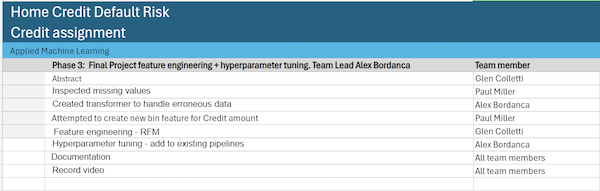